In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import haversine as hs
import warnings
warnings.filterwarnings('ignore')
import matplotlib
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import plotly.express as px


pd.options.display.float_format = '{:.2f}'.format

In [2]:
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 -lat1)
    delta_lambda = np.radians(lon2 -lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

In [3]:
apr     = pd.read_csv('D:\Google Data Analytics\Capstone Project\Cyclistic\data_2020/202004-divvy-tripdata.csv')
may     = pd.read_csv('D:\Google Data Analytics\Capstone Project\Cyclistic\data_2020/202005-divvy-tripdata.csv')
june    = pd.read_csv('D:\Google Data Analytics\Capstone Project\Cyclistic\data_2020/202006-divvy-tripdata.csv')
july    = pd.read_csv('D:\Google Data Analytics\Capstone Project\Cyclistic\data_2020/202007-divvy-tripdata.csv')
aug     = pd.read_csv('D:\Google Data Analytics\Capstone Project\Cyclistic\data_2020/202008-divvy-tripdata.csv')
sep     = pd.read_csv('D:\Google Data Analytics\Capstone Project\Cyclistic\data_2020/202009-divvy-tripdata.csv')
octo    = pd.read_csv('D:\Google Data Analytics\Capstone Project\Cyclistic\data_2020/202010-divvy-tripdata.csv')
nov     = pd.read_csv('D:\Google Data Analytics\Capstone Project\Cyclistic\data_2020/202011-divvy-tripdata.csv')
dec     = pd.read_csv('D:\Google Data Analytics\Capstone Project\Cyclistic\data_2020/202012-divvy-tripdata.csv')


In [4]:
frames = []
count  = 0
for i in [apr,may,june,july,aug,sep,octo,nov,dec]:
    count += 1 
    i['started_at'] = pd.to_datetime(i['started_at'],format='%Y-%m-%d %H:%M')
    i['ended_at']   = pd.to_datetime(i['ended_at']  ,format='%Y-%m-%d %H:%M')
    
    i ['started_day'] = i['started_at'].dt.weekday
    i ['started_day'] = i['started_day'].map({0:'Mon', 1:'Tue', 2:'Wed',3:'Thu', 
                                             4:'Fri', 5:'Sat', 6:'Sun' })
    
    i['total_duration'] = (i ['ended_at'] - i ['started_at']).astype('timedelta64[m]')
    
    i.drop(i[i['total_duration'] < 0].index,axis=0,inplace=True)
    #created a new column for path_id
    #it will help into differentiate between within station commuters and between stations commuters
    i['path_id'] = i['start_station_id'].astype(str) + ['-'] + i['end_station_id'].astype(str)
    i['path_id'] = i['start_station_id'].astype(str) + ['-'] + i['end_station_id'].astype(str)
    
    
    distances_km = []
    for row in i.itertuples():
        distances_km.append(haversine_distance(row.start_lat, row.start_lng, row.end_lat, row.end_lng))
    i['distance'] =  distances_km
    
    i['locality'] = np.where(i['start_station_name'] == i['end_station_name'],'local','not_local')
    
    i = i.dropna(inplace=True)
    print(count)

1
2
3
4
5
6
7
8
9


In [196]:
frames   = [apr,may,june,july,aug,sep,octo,nov,dec]
combined = pd.concat(frames)

In [197]:
combined.isnull().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
started_day           0
total_duration        0
path_id               0
distance              0
locality              0
dtype: int64

In [198]:
from sklearn import preprocessing
label_encoder                      = preprocessing.LabelEncoder()
combined['new_start_station_name'] = label_encoder.fit_transform(combined['start_station_name'])

In [199]:
encoder                             = combined.groupby(['start_station_name'])['new_start_station_name'].value_counts().index
combined['new_end_station_name']    = combined['end_station_name'].map(dict(encoder))

In [200]:
combined.isnull().sum()

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name        0
start_station_id          0
end_station_name          0
end_station_id            0
start_lat                 0
start_lng                 0
end_lat                   0
end_lng                   0
member_casual             0
started_day               0
total_duration            0
path_id                   0
distance                  0
locality                  0
new_start_station_name    0
new_end_station_name      1
dtype: int64

In [201]:
combined.drop(combined[combined['new_end_station_name'].isnull()].index,axis=0,inplace=True)

In [202]:
combined['new_end_station_name']    = combined['new_end_station_name'].astype(int)


In [203]:
combined['path_id'] = combined['new_start_station_name'].astype(str) + '-' + combined['new_end_station_name'].astype(str)

# Top 20 most travelled stations

In [31]:
#combined.iloc[69476]#[combined['distance']==1.3]

In [223]:
combined[combined['locality']=='not_local'].groupby(['start_station_name','end_station_name'],as_index=False).agg({'path_id':'count','total_duration':'mean','distance':'mean'}).sort_values(by='path_id',ascending=False).head(50)

,start_station_name,end_station_name,path_id,total_duration,distance
69286,Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,1915,32.55,1.32
118554,Streeter Dr & Grand Ave,Lake Shore Dr & Monroe St,1242,32.52,1.32
87792,Millennium Park,Streeter Dr & Grand Ave,1169,46.40,1.60
118611,Streeter Dr & Grand Ave,Millennium Park,1151,32.94,1.60
70757,Lakefront Trail & Bryn Mawr Ave,Theater on the Lake,1100,33.52,6.66
80036,MLK Jr Dr & 29th St,State St & 33rd St,1066,7.08,1.09
118719,Streeter Dr & Grand Ave,Theater on the Lake,1028,33.89,4.09
87638,Millennium Park,Lake Shore Dr & Monroe St,987,53.56,0.61
126723,Wells St & Huron St,Wells St & Elm St,976,6.03,0.94
114646,State St & 33rd St,MLK Jr Dr & 29th St,946,8.39,1.09


In [206]:
combined.shape

(2952035, 20)

In [207]:
Q1  = combined['total_duration'].quantile(0.25)
Q3  = combined['total_duration'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - (IQR *1.5)
upper_limit = Q3 + (IQR *1.5)

In [208]:
print('there are {} % outliers in our data'.format(round(combined[combined['total_duration'] > upper_limit].shape[0]/combined.shape[0] *100),2))

there are 8 % outliers in our data


# Considered a condition of max duration of 16 hrs(1000 mins) for the data point to be valid for our analysis

In [209]:
combined = combined[combined['total_duration'] < 1001]#.filter(like='casual',axis=1)#.value_counts()

In [213]:
3575/2952035

0.0012110290020274149

In [36]:
combined[combined['locality']=='not_local']['total_duration'].describe()

count   2613627.00
mean         20.96
std          32.04
min           0.00
25%           8.00
50%          14.00
75%          24.00
max        1000.00
Name: total_duration, dtype: float64

In [37]:
combined['started_at']  = pd.to_datetime(combined['started_at'],format='%Y-%m-%d %H:%M')
combined['ended_at']    = pd.to_datetime(combined['ended_at']  ,format='%Y-%m-%d %H:%M')
combined['month']       = combined['started_at'].dt.month
combined['date']        = combined['started_at'].dt.date
combined['day']         = combined['started_at'].dt.day
combined['hour']        = combined['started_at'].dt.hour
#combined['day of week'] = combined['started_at'].dt.dayofweek

In [38]:
member = combined[combined['member_casual']=='member']
casual = combined[combined['member_casual']=='casual']

In [39]:
#casual_nutshell = member.groupby(['start_station_name','end_station_name'],as_index=False).agg({'path_id':'count','total_duration':'mean','distance':'mean'}).sort_values(by='path_id',
 #                                                                                                         ascending=False)
#casual_nutshell

In [40]:
top_trips               = combined.groupby(['start_station_name','end_station_name','path_id']).agg({'path_id':'count'}).rename(columns ={'path_id':'id'}).reset_index().sort_values(by='id',
                                                                                                          ascending=False)
top_trips['percentage'] = (top_trips['id']/top_trips['id'].sum()) * 100

In [41]:
top_trips.head(5)

,start_station_name,end_station_name,path_id,id,percentage
119310,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,596-596,6428,0.22
69497,Lake Shore Dr & Monroe St,Lake Shore Dr & Monroe St,361-361,5910,0.20
11976,Buckingham Fountain,Buckingham Fountain,65-65,4869,0.17
88129,Millennium Park,Millennium Park,443-443,4733,0.16
61298,Indiana Ave & Roosevelt Rd,Indiana Ave & Roosevelt Rd,317-317,4536,0.15


# Calculate total trips per station

In [226]:
#Total trips per station 
trip_count               = combined.groupby(['member_casual','start_station_name',
                                                   'end_station_name','path_id']).agg({'path_id':'count','total_duration':'mean'})

trip_count               = trip_count.rename(columns ={'path_id':'id'}).reset_index().sort_values(by='id',ascending=False)
trip_count['percentage'] = (trip_count['id']/trip_count['id'].sum()) * 100

trip_count.head()

,member_casual,start_station_name,end_station_name,path_id,id,total_duration,percentage
93278,casual,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,596-596,5644,57.31,0.19
53937,casual,Lake Shore Dr & Monroe St,Lake Shore Dr & Monroe St,361-361,5247,52.45,0.18
9391,casual,Buckingham Fountain,Buckingham Fountain,65-65,4560,70.08,0.15
68778,casual,Millennium Park,Millennium Park,443-443,4541,57.30,0.15
47558,casual,Indiana Ave & Roosevelt Rd,Indiana Ave & Roosevelt Rd,317-317,3668,61.26,0.12


# Considering a condition of total 130 trips atleast for a station to be conisdered for in depth analysis

In [229]:
member_casual           = pd.pivot_table(data = trip_count , index=['path_id'],columns=['member_casual'],values=['id'])
member_casual.columns   = list(map("_".join, member_casual.columns))

member_casual['total']  = member_casual['id_casual']   + member_casual['id_member']
#print(member_casual.shape)
member_casual.head()

,id_casual,id_member,total
path_id,,,
0-0,53.00,23.00,76.00
0-11,nan,1.00,nan
0-117,nan,3.00,nan
0-125,nan,1.00,nan
0-126,2.00,nan,nan


In [230]:
low_trip_riders = member_casual[member_casual['total'] <= 100]
low_trip_riders['total'].sum()

1465277.0

In [231]:
low_trip_riders['total'].describe()

count   74723.00
mean       19.61
std        21.22
min         2.00
25%         5.00
50%        11.00
75%        26.00
max       100.00
Name: total, dtype: float64

In [235]:
member_casual           = member_casual[member_casual['total'] > 100]
member_casual           = member_casual.sort_values(by ='total',ascending=False).reset_index()
member_casual

,path_id,id_casual,id_member,total
0,596-596,5644.00,784.00,6428.00
1,361-361,5247.00,663.00,5910.00
2,65-65,4560.00,309.00,4869.00
3,443-443,4541.00,192.00,4733.00
4,317-317,3668.00,868.00,4536.00
...,...,...,...,...
6038,314-571,3.00,98.00,101.00
6039,465-26,17.00,84.00,101.00
6040,456-258,19.00,82.00,101.00
6041,676-658,27.00,74.00,101.00


In [236]:
#df =combined[combined['path_id'].isin(list(table['path_id'].value_counts().index))]
rounding_distance          = combined.groupby(['path_id'])['distance'].agg(lambda x:round(x.mean(),2))
member_casual['distance']  = member_casual['path_id'].map(dict(rounding_distance))

In [237]:
member_avg_duration                   = member.groupby(['path_id'])['total_duration'].agg(lambda x:round(x.mean(),2))
member_casual['member_avg_duration']  = member_casual['path_id'].map(dict(member_avg_duration))

In [238]:
casual_avg_duration                          = casual.groupby(['path_id'])['total_duration'].agg(lambda x:round(x.median(),2))
member_casual['casual_avg_duration']         = member_casual['path_id'].map(dict(casual_avg_duration))

In [239]:
member_casual = member_casual[['path_id','id_casual','casual_avg_duration','id_member','member_avg_duration','total']]
member_casual.rename(columns ={'path_id':'id','id_casual':'casual_count',
                               'id_member':'member_count'},inplace=True)

In [241]:
#['casual_avg_duration'].describe()

In [242]:
#combined[(combined['path_id']=='443-443') & (combined['member_casual']=='member')]['total_duration'].value_counts()

In [243]:
#combined.groupby(['path_id'])['total_duration'].agg(lambda x:round(x.mean(),2))#lambda x:round(x.mean(),2))

In [244]:
#table['locality'] = np.where(table['distance']< 0.02,'local','not_local')

In [245]:
start_station_name                  = combined.groupby(['path_id'])['start_station_name'].value_counts().index
member_casual['start_station_name'] = member_casual['id'].map(dict(start_station_name))

In [273]:
fig = px.bar(y = member_casual['start_station_name'].value_counts().head(50).index,
             x = member_casual['start_station_name'].value_counts().head(50).values)
fig.show()

In [277]:
fig = px.bar(y = member_casual['start_station_name'].head(50),
             x = member_casual['total'].head(50))
fig.show()

In [254]:
combined['start_station_name'].value_counts()

Streeter Dr & Grand Ave            32448
Clark St & Elm St                  28451
Theater on the Lake                27471
Lake Shore Dr & Monroe St          26512
Lake Shore Dr & North Blvd         25025
                                   ...  
Eggleston Ave & 69th St (*)            3
Base - 2132 W Hubbard Warehouse        1
Western Ave & 104th St                 1
Stewart Ave & 63rd St (*)              1
Hegewisch Metra Station                1
Name: start_station_name, Length: 689, dtype: int64

In [56]:
member_casual['percent']  = (member_casual['total']/member_casual['total'].sum()) * 100
#top_member_casual #=member_casual.head(3000)
#top_member_casual#['start_station_name'].value_counts().head(50)

In [141]:
member_casual['percent_member'] = member_casual['member_count']/member_casual['total']
member_casual['percent_casual'] = member_casual['casual_count']/member_casual['total']
member_casual['casual_count'].sum()

507135.0

In [289]:
member_casual#.to_csv('member_casual.csv')

,id,casual_count,casual_avg_duration,member_count,member_avg_duration,total,start_station_name
0,596-596,5644.00,44.00,784.00,22.30,6428.00,Streeter Dr & Grand Ave
1,361-361,5247.00,36.00,663.00,19.04,5910.00,Lake Shore Dr & Monroe St
2,65-65,4560.00,47.00,309.00,20.25,4869.00,Buckingham Fountain
3,443-443,4541.00,45.00,192.00,17.86,4733.00,Millennium Park
4,317-317,3668.00,50.00,868.00,23.50,4536.00,Indiana Ave & Roosevelt Rd
...,...,...,...,...,...,...,...
6038,314-571,3.00,7.00,98.00,6.78,101.00,Indiana Ave & 26th St
6039,465-26,17.00,7.00,84.00,5.81,101.00,Ogden Ave & Race Ave
6040,456-258,19.00,37.00,82.00,30.27,101.00,Museum of Science and Industry
6041,676-658,27.00,6.00,74.00,7.41,101.00,Wolcott Ave & Polk St


In [281]:
combined['path_id'].value_counts()

596-596    6428
361-361    5910
65-65      4869
443-443    4733
317-317    4536
           ... 
491-472       1
92-277        1
452-214       1
196-520       1
221-516       1
Name: path_id, Length: 136050, dtype: int64

In [157]:
#combined[combined['start_station_name']=='Clark St & Elm St']['path_id'].value_counts().head(60)

In [58]:
combined['total_trips']= combined['path_id'].map(dict(combined['path_id'].value_counts()))

2948460

In [162]:
member_casual['total'].sum()/trip_count['id'].sum()

0.37531253603576104

In [165]:
low_trip_riders['total'].sum()/trip_count['id'].sum()

0.5759376081072831

In [62]:
Q1          = trip_count['id'].quantile(0.25)
Q3          = trip_count['id'].quantile(0.75)
IQR         = Q3 - Q1
lower_limit = Q1 - (IQR *1.5)
upper_limit = Q3 + (IQR *1.5)

In [63]:
#subscriber_trips[subscriber_trips['id']>subscriber_trips['id'].quantile(0.90)]

In [214]:
combined.groupby(['member_casual'])['path_id'].count()#.plot(kind='bar')

member_casual
casual    1245839
member    1702621
Name: path_id, dtype: int64

In [216]:
combined['member_casual'].value_counts()/combined.shape[0]

member   0.58
casual   0.42
Name: member_casual, dtype: float64

In [156]:
pd.options.plotting.backend = "plotly"

combined.groupby(['started_day','member_casual'])['path_id'].count().unstack().plot(kind='bar')

<AxesSubplot:ylabel='month'>

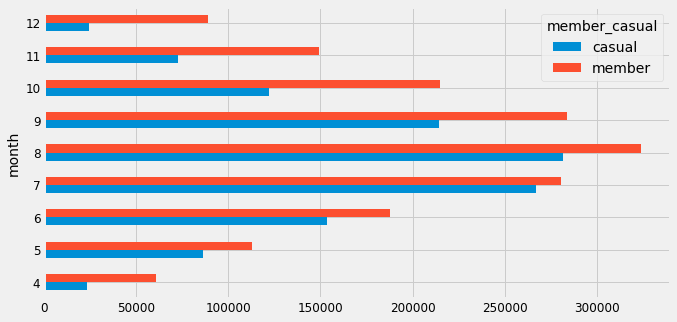

In [66]:
combined.groupby(['month','member_casual'])['path_id'].count().unstack().plot(kind='barh',figsize=(10,5))

In [70]:
def applyer(row):
    if row== 'Sat' or row == 'Sun':
        return 1
    else:
        return 0 

combined['weekend']=combined['started_day'].apply(applyer)

In [71]:
#combined.groupby('weekend')['total_duration'].sum().plot(kind='bar',figsize=(10,5))

<AxesSubplot:xlabel='weekend'>

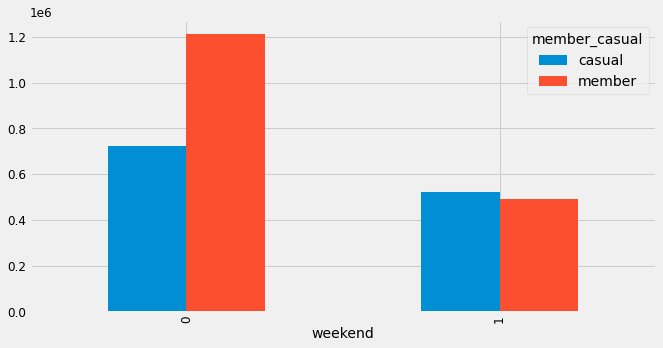

In [78]:
combined.groupby(['weekend','member_casual'])['path_id'].count().unstack().plot(kind='bar',figsize=(10,5))

<AxesSubplot:xlabel='hour'>

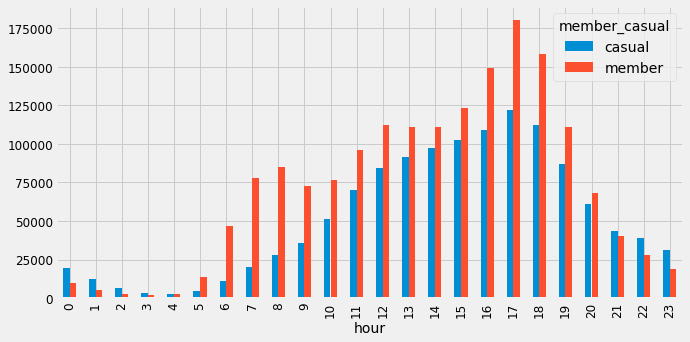

In [114]:
combined.groupby(['hour','member_casual'])['path_id'].count().unstack().plot(kind='bar',figsize=(10,5))

In [87]:
#combined.groupby(['hour','member_casual'])['path_id'].count().unstack().plot(kind='bar',figsize=(10,5))

<AxesSubplot:xlabel='day'>

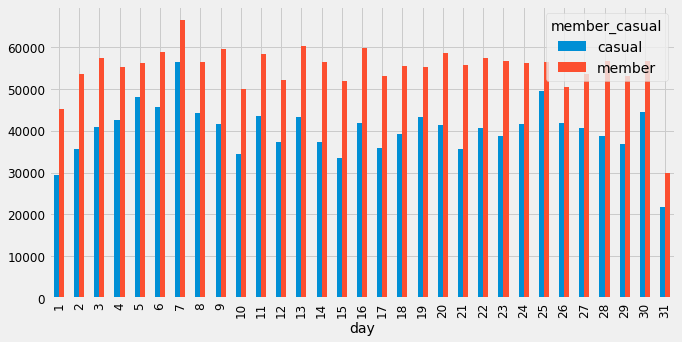

In [115]:
#yearly analysis
combined.groupby(['day','member_casual'])['path_id'].count().unstack().plot(kind='bar',figsize=(10,5))

<AxesSubplot:xlabel='month'>

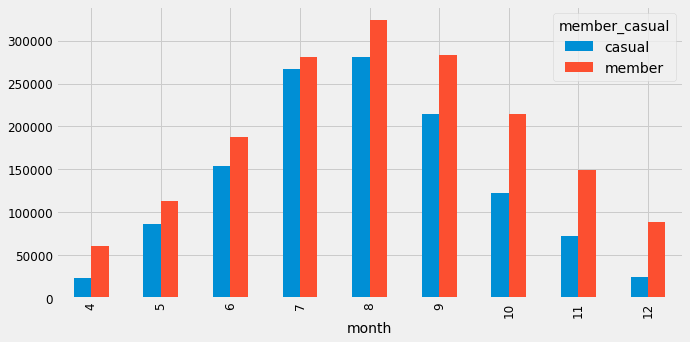

In [116]:
combined.groupby(['month','member_casual'])['path_id'].count().unstack().plot(kind='bar',figsize=(10,5))

<AxesSubplot:xlabel='month'>

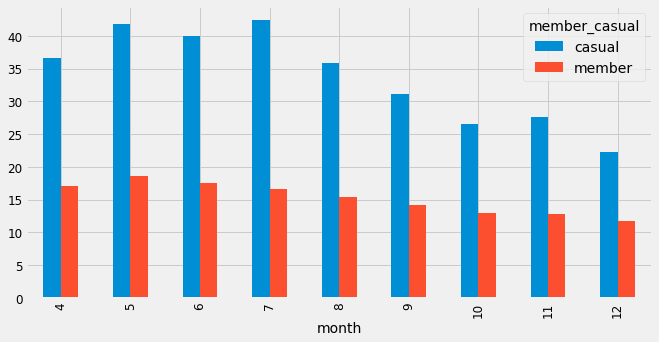

In [110]:
combined.groupby(['month','member_casual'])['total_duration'].mean().unstack().plot(kind='bar',figsize=(10,5))

In [99]:
combined['season']= combined['month'].replace({4:'april', 5:'may', 6:'june',7:'july',
                                               8:'august',9:'sept',10:'oct',11:'nov',12:'dec'})

In [119]:
def applyer(row):
    if row == 'april' or row == 'may':
        return 'spring'
    elif row== 'june' or row == 'july' :
        return 'summer'
    elif row== 'sept' or row == 'oct' or row =='august': 
        return 'fall'
    else:
        return 'winter'
    

combined['new_season']=combined['season'].apply(applyer)

<AxesSubplot:xlabel='new_season'>

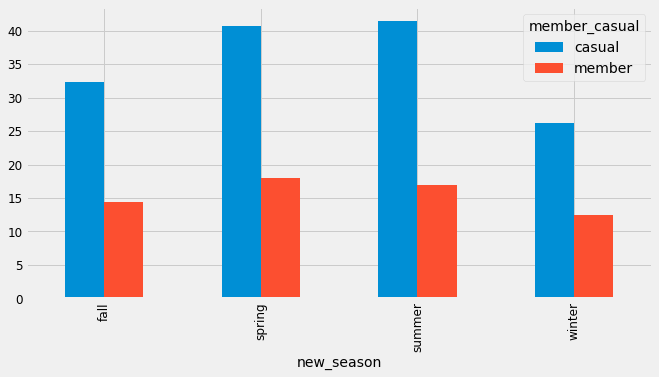

In [123]:
combined.groupby(['new_season','member_casual'])['total_duration'].mean().unstack().plot(kind='bar',figsize=(10,5))

In [124]:
combined.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'started_day', 'total_duration', 'path_id', 'distance',
       'locality', 'month', 'date', 'day', 'hour', 'new_start_station_name',
       'new_end_station_name', 'total_trips', 'weekend', 'season',
       'new_season'],
      dtype='object')

In [125]:
#combined.to_csv('Combined.csv')

In [195]:
combined['total_duration'].describe()

count   2948460.00
mean         23.86
std          36.80
min           0.00
25%           8.00
50%          15.00
75%          27.00
max        1000.00
Name: total_duration, dtype: float64